# Transformación de Joukowsky

La transformación de Joukowsky nos permite mapear un círculo a un perfil aerodinámico. Si $\zeta = \xi + i\eta$ son los puntos de un círculo en el plano $\zeta$, la tranformación de Joukowsky es

\begin{equation}
z = \frac{a}{2}\left(\zeta + \frac{1}{\zeta}\right)
\end{equation}

donde $z=x+iy$ son los puntos que definen el perfil aerodinámico, y $a$ es un factor que define el tamaño. Eso si, existe una condición: el contorno del círculo debe intersectar el punto $\xi=1, \eta=0$, y el punto $\xi=-1, \eta=0$ debe estar contenido dentro del círculo. De no cumplir estas condicones, la transformación genera geomterías que no se asemejan a un perfil aerodinámico.

A continuación, generaremos un círculo y veremos que pasa

(-1.3459574579560356, 1.3459574579560356)

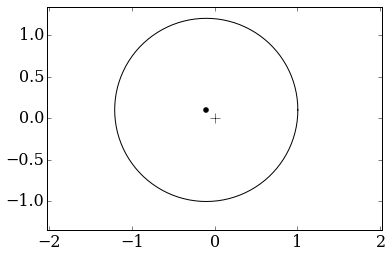

In [35]:
import numpy
from math import pi
from matplotlib import pyplot, mlab
%matplotlib inline
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

def circulo(centro, R, N):
    alpha = numpy.linspace(0,2*pi,N)

    x_prime = R*numpy.cos(alpha)
    y_prime = R*numpy.sin(alpha)
    
    zeta = numpy.array(x_prime+1j*y_prime)
    
    zeta += centro
    
    return zeta
    

N = 101
centro_x = -0.1
centro_y = 0.1   

# Radio para que circulo intersecte punto (1,0)
# Ojo: el punto (-1,0) debiese queda DENTRO del circulo (no lo checkeo aca)
R = numpy.sqrt((1-centro_x)**2+centro_y**2)

# Tamaño del perfil
a = 1

centro = centro_x+centro_y*1j

# Generar cilindro
zeta = circulo(centro, R, N)

x_cil = numpy.real(zeta)
y_cil = numpy.imag(zeta)

pyplot.figure()

fig=pyplot.plot(x_cil,y_cil,c='k')
fig2=pyplot.plot(0, 0, marker='+', markersize=10, c='k')
fig3=pyplot.plot(centro_x,centro_y,marker='o', markersize=5, c='k')
pyplot.axis('equal')
pyplot.xlim([-(R+numpy.abs(centro))-0.1,(R+numpy.abs(centro))+0.1])
pyplot.ylim([-(R+numpy.abs(centro))-0.1,(R+numpy.abs(centro))+0.1])

Como ven, generamos un círculo centrado en `centro_x` y `centro_y`. El radio lo definimos para asegurarnos que el contorno intersecte el punto $\xi=1, \eta=0$. El origen está marcado con una cruz y el centro del cículo con un punto.

A continuación, definimos una función que realiza la tranformación. Veamos que pasa!

(-1.1, 1.1)

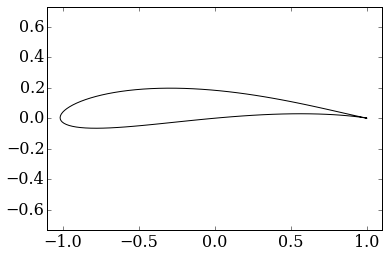

In [36]:
# Generar perfil de Joukouski
def Joukowsky(zeta, a):
    z = a/2. * (zeta + 1/zeta)

    return z

z = Joukowsky(zeta, a)

x = numpy.real(z)
y = numpy.imag(z)

pyplot.clf()
pyplot.figure()
fig=pyplot.plot(x,y,c='k')
pyplot.axis('equal')
pyplot.xlim([-a-0.1,a+0.1])
pyplot.ylim([-a-0.1,a+0.1])
#pyplot.savefig('perfil_curvo.pdf')

Eso se parece mucho a la sección transversal de un ala: es una geometría aerodinámica, con una punta en la parte posterior. 

La geometría de este perfil alar depende del centro del círculo inicial. Si varían `centro_x` el perfil se ensancha, y si varían `centro_y` se hace cada vez más curvo ¡Pruébenlo!


# Flujo alrededor de un perfil alar

Utilicemos lo que acabamos de aprender para estudiar el flujo alrededor de un perfil alar. Con la superposición de un flujo uniforme con un doblete y un vórtice obtenemos el flujo alrededor de un cilindro, y a ese resultado podemos aplicarle la transformación de Joukowsky para visualizar las líneas de flujo alrededor del perfil alar.

Usando variables complejas, podemos escribir la función corriente del flujo que entra a un ángulo $\alpha$ alrededor de un cilindro centrado en $z_0=x_0+iy_0$ como:

\begin{align}
\psi &= \psi_\text{Uniforme} + \psi_\text{doblete} + \psi_\text{vortice} \\
     &= \Im\left[U_\infty z e^{-i\alpha} + \frac{K}{z-z_0}e^{i\alpha} - i\frac{\Gamma}{2\pi}\log(z-z_0)\right]
\end{align}

donde $\Im$ indica que es la parte imaginaria, $U_\infty$ es la velocidad de entrada, $K$ la fuerza del doblete, y $\Gamma$ la circulación alrededor del vórtice. Grafiquemos un caso:

(-3.0, 3.0)

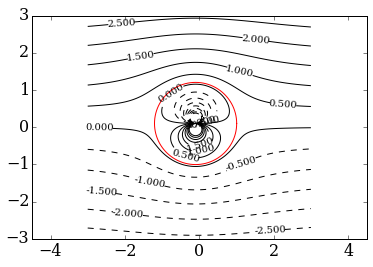

In [37]:
nx = 300
L = 6.0
xp = numpy.linspace(-L/2,L/2,nx)
Xp,Yp = numpy.meshgrid(xp,xp)

Zp = Xp + Yp*1j

alpha_at = 0*pi/180.

# Flujo uniforme
U_inf = 1.
PHI_U = U_inf*Zp*numpy.exp(-1j*alpha_at)

# Doblete (corrido a 'centro')
K= R**2*U_inf
PHI_d = K/(Zp-centro)*numpy.exp(1j*alpha_at)

# Vortice (corrido a 'centro')
Gamma = -0.
PHI_v = -1j*Gamma/(2*pi)*numpy.log(Zp-centro)

# Constante extra para que psi=0 sea siempre el cilindro
PHI_c = PHI_U + PHI_d + PHI_v #- 1j*Gamma/(2*pi)*numpy.log(R-numpy.abs(centro))

psi_c = numpy.imag(PHI_c)
phi_c = numpy.real(PHI_c)

contours = numpy.arange(-4,4,0.5)

pyplot.figure()
C = pyplot.contour(Xp, Yp, psi_c, contours, colors='k')
#C3 = pyplot.contour(Xp, Yp, phi_c, contours, colors='k')
C2 = pyplot.plot(x_cil,y_cil,c='r')
pyplot.clabel(C, inline=1, fontsize=10)

pyplot.axis('equal')
pyplot.xlim([-L/2,L/2])
pyplot.ylim([-L/2,L/2])
#pyplot.savefig('flujo_cil.pdf')

Apliquemos la tranformación de Joukowsky sobre este caso. Vamos a tener que redistribuir la data 'transformada' en un arreglo unidimensional, pues `Python` solamente acepta graficar curvas de nivel de mallas regulares (cartesianos) y la malla transfomada no lo es. Además, el flujo dentro del cilindro no tiene significado físico, por lo que sacamos esos puntos para que no nos arruine la interpolación.

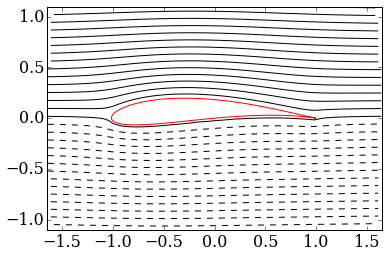

In [38]:
from scipy import interpolate

# Conviene pasar Zp y psi a 1D (por numpy.where y mlab.griddata)
Zp_1D = numpy.ravel(Zp)
psi_c_1D = numpy.ravel(psi_c)

# Los puntos dentro del cilindro no tienen significado fisico y los sacamos
fuera_cil = numpy.where(numpy.abs(Zp_1D-centro)>R)[0]

psi_perfil = psi_c_1D[fuera_cil]

Z = Joukowsky(Zp_1D[fuera_cil], a)
X = numpy.ravel(numpy.real(Z))
Y = numpy.ravel(numpy.imag(Z))


# pyplot.countour funciona solamente con mallas regulares
# Interpolar X,Y a malla regular
xi= numpy.linspace(-L/2,L/2,200)
Xi,Yi = numpy.meshgrid(xi,xi)

psi_i = mlab.griddata(X, Y, psi_perfil, Xi, Yi, interp='linear')


pyplot.clf()
pyplot.figure()
contours = numpy.arange(-4,4,0.15)

C=pyplot.contour(Xi, Yi, psi_i, contours, colors='k')
C2=pyplot.plot(x,y,c='r')
#pyplot.clabel(C, inline=1, fontsize=10)

pyplot.axis('equal')
pyplot.xlim([-a-0.1,a+0.1])
pyplot.ylim([-a-0.1,a+0.1])
pyplot.savefig('flujo_perfil_gamma3.pdf')

# Condición de Kutta

El flujo resultante se ve físicamente posible, ¿o no? Fíjense en la parte posterior: las líneas de flujo salen de la punta hacia arriba. Esto no es muy físico, pues uno esperaría que la línea de flujo salga por la parte posterior con el mismo ángulo que la punta. En el ejemplo usamos $\Gamma=-1$, y podemos modificar las líneas de flujo variando $\Gamma$.

La pregunta entonces es ¿Cuánto tiene que ser $\Gamma$ para que la línea de flujo a la salida sea física? En palabras más físicas ¿Cuánta es la circulación generada por el perfil alar? Eso se conoce como la condición de Kutta. Si modificamos $\Gamma=-5$, nos pasa lo contrario, las líneas de flujo a la salida parecen apuntar hacia abajo. Ahora, si intentan $\Gamma=-3.6$, la línea de flujo sale del perfil alar con el ángulo de la punta. Esto es un resultado que tiene sentido físico, por lo tanto, es un buen modelo para el flujo alrededor de un perfil alar.

La utilidad de esto es que ahora podemos calcular la fuerza de sustentación sobre el perfil alar, puesa sabemos que la sustentación sobre un cilindro con circulación es $L=\rho\Gamma U_\infty$. Si llegamos a que la circulación para que se cumpla la condición de Kutta es $\Gamma_K$, entonces la fuerza de sustentación sobre el perfil es:

\begin{equation}
L=\rho\Gamma_K U_\infty
\end{equation}

En palabras más técnicas, la condición de Kutta dice que un perfil aerodinámico producirá en el flujo la cantidad de ciruclación necesaria para que el punto de estancamiento esté en la parte puntiaguda. El que exista una transformación analítica que nos lleve a un perfil aerodinámico es un caso muy particular de los perfiles de Joukousky, pero no es el caso general. Por lo tanto, para un perfil sin una transformación hay que monitorear la velocidad a la salida del perfil para ver si hay estancamiento, y así encontrar $\Gamma_K$.

Para Joukowsky, podemos aprovechar que si existe una transformación para calcular analíticamente $\Gamma_K$. Sabemos que el punto del cilindro que mapea a la punta es el punto singular $(1,0)$, por lo tanto, la condición de Kutta se cumple tal que el punto de estancamiento en el cilindro se encuentre en $(1,0)$

Usando variable compleja, la función potencial en el caso del cilindro es

\begin{equation}
\Phi_c = U_\infty z e^{-i\alpha} + \frac{K}{z-z_0}e^{i\alpha} - i\frac{\Gamma}{2\pi}\log(z-z_0)
\end{equation}

y la velocidad

\begin{equation}
V = u+iv = \frac{d\Phi_c}{dz} = U_\infty e^{-i\alpha} - \frac{K}{(z-z_0)^2}e^{i\alpha} - i\frac{\Gamma}{2\pi(z-z_0)}
\end{equation}

Sabiendo que $R = \sqrt{K/U_\infty}$, y que en el punto de estancamiento $V(1,0)=0$, podemos despejar $\Gamma_K$

\begin{equation}
\Gamma_K = -2\pi i\left[ U_\infty e^{-i\alpha}(z-z_0) - \frac{R^2U_\infty}{z-z_0}e^{i\alpha}\right]
\end{equation}

A continuación, calculemos $\Gamma_K$, y veamos si coincide con el $\Gamma_K=-3.6$ que obtuvimos visualmente.

In [39]:
p_sing = 1.+0*1j # punto singular
Gamma_k = -2*pi*1j*(U_inf*numpy.exp(-1j*alpha_at)*(p_sing-centro) - R**2*U_inf*numpy.exp(1j*alpha_at)/(p_sing-centro))
print Gamma_k

(-1.25663706144-1.3951473992e-15j)
